<a href="https://colab.research.google.com/github/jblancoperez/fiap-desafio/blob/main/C%C3%B3pia_de_00_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR




#!{sys.executable} -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension

#!{sys.executable} -m pip install -U lafrom lazypredict.Supervised import LazyClassifier, LazyRegressor

def cm_to_inch(value):
    return value/2.54
#arquivo = pd.read_csv('https://raw.githubusercontent.com/jblancoperez/fiap-desafio/main/solicitacoescredito.csv')

In [ ]:
arquivo = pd.read_csv('./solicitacoescredito.csv')
aprovadosAnalista=arquivo.loc[arquivo['status'].isin(['AprovadoAnalista','AprovadoComite'])]
aprovadosAnalista.head()








In [2]:
#Feature selection class to eliminate multicollinearity

#Baseado em  https://www.youtube.com/watch?v=ioXKxulmwVQ&feature=youtu.be
class MultiCollinearityEliminator():
    
    #Class Constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold

    #Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target = False):
        #Checking we should include the target in the correlation matrix
        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)
            
            #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            #Setting min_period to 30 for the sample size to be statistically significant (normal) according to 
            #central limit theorem
            corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()
        #Target is included for creating the series of feature to target correlation - Please refer the notes under the 
        #print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    #Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        #After obtaining the list of correlated features, this method will help to view which variables 
        #(in the list of correlated features) are least correlated with the target
        #This way, out the list of correlated features, we can ensure to elimate the feature that is 
        #least correlated with the target
        #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
        
        #Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)                           
        #Creating the required dataframe, then dropping the target row 
        #and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                    
        #print(corrWithTarget, '\n')
        return corrWithTarget

    #Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        #Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        #Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            #Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():                                            
                if(row[column]>self.threshold) and (row[column]<1):
                    #Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        #print(colCorr, '\n')
        return colCorr

    #Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        #Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():
            #print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    #Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        #Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            #Obtaining the dataframe after deleting the feature (from the list of correlated features) 
            #that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            #Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df

In [8]:
arquivo = pd.read_csv('./solicitacoescredito.csv')
arquivo.info()
arquivo['empresa_MeEppMei'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973 entries, 0 to 8972
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           8973 non-null   int64  
 1   razaoSocial                  8973 non-null   object 
 2   nomeFantasia                 8973 non-null   object 
 3   cnpjSemTraco                 8973 non-null   object 
 4   maiorAtraso                  8973 non-null   int64  
 5   margemBrutaAcumulada         8973 non-null   float64
 6   percentualProtestos          7475 non-null   float64
 7   primeiraCompra               8867 non-null   object 
 8   prazoMedioRecebimentoVendas  8973 non-null   int64  
 9   titulosEmAberto              8973 non-null   float64
 10  valorSolicitado              8973 non-null   float64
 11  status                       8973 non-null   object 
 12  definicaoRisco               8973 non-null   object 
 13  diferencaPercentua

0     True
1      NaN
2     True
3     True
4    False
Name: empresa_MeEppMei, dtype: object

In [9]:
#Remove MultiCollinearity in input
arquivo = pd.read_csv('./solicitacoescredito.csv')
df=arquivo.loc[arquivo['status'].isin(['AprovadoAnalista','AprovadoComite'])]
df=df.loc[df['empresa_MeEppMei'].isin([True])]

df=df.drop(['numero_solicitacao','razaoSocial','nomeFantasia','cnpjSemTraco','dataAprovadoEmComite','dataAprovadoNivelAnalista'],axis=1)


invalidDates = [
    '0019-02-06T03:06:00',
    '0001-01-01T03:06:00',
    '0001-01-01T06:12:00',
    '0019-02-06T03:06:00',
    '0219-12-31T03:06:00'
]

for d in invalidDates:
    df['periodoBalanco']=df['periodoBalanco'].replace(d,np.nan)
df['periodoBalanco']=pd.to_datetime(df['periodoBalanco'],errors='coerce')
df['primeiraCompra']=pd.to_datetime(df['primeiraCompra'],errors='coerce')



df['eprimeira']=df['primeiraCompra'].isna()
df=df.drop(['primeiraCompra'],axis=1)

ftRemover = MultiCollinearityEliminator(df,'valorAprovado',0.7)
df=ftRemover.autoEliminateMulticollinearity()
df=df.drop(['periodoBalanco'],axis=1)
df.info()
df=pd.get_dummies(df, columns=["definicaoRisco","empresa_MeEppMei","restricoes","intervaloFundacao","status"], prefix=["definicaoRisco","mei","restricoes","intervaloFundacao","status"])
#Create dummy columns
df=df.fillna(method='bfill',axis=1)
y = df['valorAprovado']
X= df.drop(['valorAprovado'], axis=1)
X = StandardScaler().fit_transform(X)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2894 entries, 0 to 8960
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  2894 non-null   int64  
 1   percentualProtestos          2407 non-null   float64
 2   prazoMedioRecebimentoVendas  2894 non-null   int64  
 3   titulosEmAberto              2894 non-null   float64
 4   valorSolicitado              2894 non-null   float64
 5   status                       2894 non-null   object 
 6   definicaoRisco               2894 non-null   object 
 7   diferencaPercentualRisco     2894 non-null   float64
 8   percentualRisco              2894 non-null   float64
 9   dashboardCorrelacao          2894 non-null   float64
 10  valorAprovado                2894 non-null   float64
 11  ativoCirculante              1456 non-null   float64
 12  endividamento                1456 non-null   float64
 13  duplicatasAReceber

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=2)]: Us

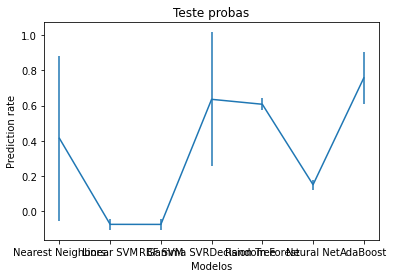

In [23]:
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM",
         "Gamma SVR"
         #"Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         #"Naive Bayes", 
         #"QDA"
        ]

classifiers = [
    KNeighborsRegressor(3),
    SVR(kernel="linear", C=0.025),
    SVR(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    MLPRegressor(alpha=1, max_iter=1000),
    AdaBoostRegressor(),
    #QuadraticDiscriminantAnalysis()
    ]
l=len(classifiers)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

list_scores=list()
list_std=list()
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = cross_val_score(clf,X,y,n_jobs=2,verbose=1)
    list_scores.append(score.mean())
    list_std.append(score.std())

    
plt.errorbar(names,list_scores,np.array(list_std))
plt.title('Teste probas')
plt.xlabel('Modelos')
plt.ylabel('Prediction rate')


plt.show()
    
    #rom sklearn.metrics import mean_absolute_percentage_error

    #print ("{} mean_squared_error {}".format(name,score.mean()))
    #score = cross_val_score(clf,X,y,scoring = "neg_mean_absolute_percentage_error")
    #mean= np.mean(score)
    #print ("{} mean_absolute_percentage_error {}".format(name,score))
    #y_predict=clf.predict(X_test)
    #saida = { "test": y_test, "predict" : y_predict}
    #newDf= pd.DataFrame(saida)
    #newDf.head()
    
    
   




In [ ]:

from sklearn.metrics import SCORERS
print(SCORERS.keys())

In [ ]:
newDf.head()